In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics as stat
import csv
import requests
import os
from seaborn import set_style
from tqdm import tqdm
import PIL
from PIL import Image

set_style('white')


#Fill missing data using the ratio of nearby data
def fill(df:'pd.DataFrame', date:'pd.Timestamp'):
    before=df.loc[df.time>date]
    before.reset_index(drop=True,inplace=True)
    after=df.loc[df.time<date]
    after.reset_index(drop=True,inplace=True)
    interval=int((before.time.values[-1]-after.time[0]).seconds/60)
    temp=pd.DataFrame({})
    temp['time']=[before.time.values[-1]-pd.Timedelta(i+1,'m') for i in range(interval-1)]
    for col in df.columns[1:]:
        temp[col]=[float(before.tail(1)[col])-(float(before.tail(1)[col])-float(after.head(1)[col]))*(i+1)/interval for i in range(interval-1)]
    df=pd.concat([before,temp,after])
    df.reset_index(drop=True,inplace=True)
    return df

def datafill(df:'pd.DataFrame'):
    df.reset_index(drop=True,inplace=True)
    period=df.time[0]-df.time.values[-1]
    end=pd.Timestamp(df.time[0].year,df.time[0].month,df.time[0].day,9,30)
    start=pd.Timestamp(df.time[0].year,df.time[0].month,df.time[0].day,15,59)
    for i in range(period.days+1):
        td = pd.Timedelta(i, 'd')
        track=start-td
        while track>=end-td:
            if track not in df.time.values:
                df=fill(df,track)
            track-=pd.Timedelta(1,'m')
    return df

#Define the feature 'crossover' that measures the divergence between 'open' and 'MACD'. Return the 'crossover' value and 
#the latest two indices L[0] and L[1] where MACD line crosses Signal line. The 'open' and 'MACD' are normalized.
#There are three parts in the 'crossover value'. (nopen[L[0]]-nopen[L[1]])-(nmacd[L[0]]-nmacd[L[1]]) measures the divergence.
#nopen[119]-nmacd[119], which is the current difference between 'open' and 'MACD', measures the momentum consumed since L[0].
#L[0]/120 measures the momentum decay since L[0] because of time. The final value lies in the interval (-1,1)
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
def crossover(S):
    L=[]
    for i in range(119):
        if len(L)==2: break
            
        if (S[f'MACD {119-i}']-S[f'MACD_Signal {119-i}'])*(
            S[f'MACD {119-i-1}']-S[f'MACD_Signal {119-i-1}'])<=0:
            if abs(S[f'MACD {119-i}']-S[f'MACD_Signal {119-i}'])<abs(
                S[f'MACD {119-i-1}']-S[f'MACD_Signal {119-i-1}']):
                L.append(119-i)
            else:
                L.append(119-i-1)
                   
    if len(L)==1: return 0, L[0], 0
    if len(L)==0: return 0, 0, 0
    nopen=sc.fit_transform(S[[f'open {i}' 
                        for i in range(120)]].values.reshape(-1,1)).ravel()
    nmacd=sc.fit_transform(S[[f'MACD {i}' 
                        for i in range(120)]].values.reshape(-1,1)).ravel()
    return ((nopen[L[0]]-nopen[L[1]])-(nmacd[L[0]]-nmacd[L[1]])+
            nopen[119]-nmacd[119])*(L[0]/120)/3, L[0], L[1]    

In [2]:
# Save your AlphaVantage API key as an environment variable locally as "ALPHAVANTAGE_API_KEY". See https://algotrading101.com/learn/alpha-vantage-guide/.
# Update SPY_prices.csv

api_key = os.getenv('ALPHAVANTAGE_API_KEY')  

SPY_URL = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=SPY&interval=1min&outputsize=full&apikey={api_key}'
r = requests.get(SPY_URL)
data = r.json()

df1 = pd.DataFrame(data['Time Series (1min)']).transpose()
df1 = df1.reset_index()
df1.columns = ['time','open','high','low','close','volume'] 
df1.time = pd.to_datetime(df1.time)
df1[['open','high','low','close','volume']] = df1[['open','high','low','close','volume']].astype(float)
display(df1)                                        #display the new data from AlphaVantage

#compare it with the old data and update the data
Spy_price = pd.read_csv('SPY_prices.csv', parse_dates=['time'])
ptime = Spy_price.time[0]
df1 = df1.loc[df1.time>=pd.Timestamp(ptime.year,ptime.month,ptime.day)+pd.Timedelta(1,'d')]

if df1.empty:
    print('No update available')
    
else:
    df1 = datafill(df1)                                # fill the missing values between 9:30 and 15:59
    newprice=pd.concat([df1,Spy_price],axis=0)
    newprice.to_csv('SPY_prices.csv',index=False)
    print(f'SPY prices updated {(df1.time[0]-df1.time.values[-1]).days+1} days')

,time,open,high,low,close,volume
0,2023-09-08 20:00:00,445.5200,445.5200,445.5200,445.5200,661065
1,2023-09-08 19:59:00,445.2000,445.2000,445.1100,445.1100,4178
2,2023-09-08 19:58:00,445.2400,445.2400,445.1500,445.2000,241
3,2023-09-08 19:57:00,445.2300,445.2900,445.1500,445.2100,19921
4,2023-09-08 19:56:00,445.3000,445.3200,445.1800,445.2300,5307
...,...,...,...,...,...,...
14125,2023-08-18 04:04:00,436.2600,436.3500,436.2200,436.3000,583
14126,2023-08-18 04:03:00,436.0200,436.2200,436.0200,436.2000,1760
14127,2023-08-18 04:02:00,436.0400,436.0400,435.9400,435.9900,1526
14128,2023-08-18 04:01:00,435.9700,436.0900,435.9700,436.0900,9782


SPY prices updated 4 days


In [3]:
# Update SPY_MACD.csv

api_key = os.getenv('ALPHAVANTAGE_API_KEY')  

MACD_URL = f'https://www.alphavantage.co/query?function=MACDEXT&symbol=SPY&interval=1min&fastmatype=1&slowmatype=1&signalmatype=1&series_type=open&apikey={api_key}'
r = requests.get(MACD_URL)
data = r.json()
df2 = pd.DataFrame(data['Technical Analysis: MACDEXT']).transpose()
df2 = df2.reset_index()
df2 = df2.rename(columns={'index':'time'})
df2 = df2.reindex(columns=['time','MACD','MACD_Hist','MACD_Signal'])
df2.time = pd.to_datetime(df2.time)
df2[['MACD','MACD_Hist','MACD_Signal']] = df2[['MACD','MACD_Hist','MACD_Signal']].astype(float)
display(df2)                                       #display the new data from AlphaVantage

#compare it with the old data and update the data
Spy_MACD = pd.read_csv('SPY_MACD.csv', parse_dates=['time'])
ptime = Spy_MACD.time[0]
df2 = df2.loc[df2.time>=pd.Timestamp(ptime.year,ptime.month,ptime.day)+pd.Timedelta(1,'d')]

if df2.empty:
    print('No update available')

else:
    df2 = datafill(df2)                               # fill the missing values between 9:30 and 15:59
    newMACD = pd.concat([df2,Spy_MACD],axis=0)
    newMACD.to_csv('SPY_MACD.csv',index=False)
    print(f'SPY MACD updated {(df2.time[0]-df2.time.values[-1]).days+1} days')

,time,MACD,MACD_Hist,MACD_Signal
0,2023-09-08 20:00:00,-0.0149,0.0284,-0.0433
1,2023-09-08 19:59:00,-0.0411,0.0093,-0.0504
2,2023-09-08 19:58:00,-0.0414,0.0113,-0.0527
3,2023-09-08 19:57:00,-0.0452,0.0103,-0.0555
4,2023-09-08 19:56:00,-0.0485,0.0096,-0.0581
...,...,...,...,...
14092,2023-08-18 04:37:00,-0.0519,0.0016,-0.0535
14093,2023-08-18 04:36:00,-0.0537,0.0002,-0.0539
14094,2023-08-18 04:35:00,-0.0491,0.0049,-0.0540
14095,2023-08-18 04:34:00,-0.0568,-0.0015,-0.0552


SPY MACD updated 4 days


In [4]:
# Update SPY_RSI.csv

api_key = os.getenv('ALPHAVANTAGE_API_KEY')  

MACD_URL = f'https://www.alphavantage.co/query?function=RSI&symbol=SPY&interval=1min&time_period=14&series_type=open&apikey={api_key}'
r = requests.get(MACD_URL)
data = r.json()
df3 = pd.DataFrame(data['Technical Analysis: RSI']).transpose()
df3 = df3.reset_index()
df3 = df3.rename(columns={'index':'time'})
df3.time = pd.to_datetime(df3.time)
df3['RSI'] = df3['RSI'].astype(float)
display(df3)                                        #display the new data from AlphaVantage

#compare it with the old data and update the data
Spy_RSI = pd.read_csv('SPY_RSI.csv', parse_dates=['time'])
ptime = Spy_RSI.time[0]
df3 = df3.loc[df3.time>=pd.Timestamp(ptime.year,ptime.month,ptime.day)+pd.Timedelta(1,'d')]

if df3.empty:
    print('No update available')

else:
    df3 = datafill(df3)                               # fill the missing values between 9:30 and 15:59
    newRSI = pd.concat([df3,Spy_RSI],axis=0)
    newRSI.to_csv('SPY_RSI.csv',index=False)
    print(f'SPY RSI updated {(df3.time[0]-df3.time.values[-1]).days+1} days')
 



,time,RSI
0,2023-09-08 20:00:00,63.0872
1,2023-09-08 19:59:00,44.0519
2,2023-09-08 19:58:00,46.8565
3,2023-09-08 19:57:00,46.0593
4,2023-09-08 19:56:00,51.0358
...,...,...
14111,2023-08-18 04:18:00,53.7090
14112,2023-08-18 04:17:00,54.7541
14113,2023-08-18 04:16:00,67.5753
14114,2023-08-18 04:15:00,69.0042


SPY RSI updated 4 days


In [5]:
#Select 'time', 'open', and 'volume' data between 9:30 am and 4:00 pm
L = []
period = df1.time[0]-df1.time.values[-1]
for i in range(period.days+1):
    td = pd.Timedelta(i, 'd')
    L.append(df1.loc[(df1.time>=pd.Timestamp(df1.time[0].year,df1.time[0].month,df1.time[0].day,9,30)-td) &
                       (df1.time<pd.Timestamp(df1.time[0].year,df1.time[0].month,df1.time[0].day,16)-td),['time','open','volume']])
df1 = pd.concat(L)
df1 = df1.reset_index(drop=True)

#Select 'time', 'MACD', 'MACD_Hist', and 'MACD_Signal' data between 9:30 am and 4:00 pm
LL = []
period = df2.time[0]-df2.time.values[-1]
for i in range(period.days+1):
    td = pd.Timedelta(i, 'd')
    LL.append(df2.loc[(df2.time>=pd.Timestamp(df2.time[0].year,df2.time[0].month,df2.time[0].day,9,30)-td) &
                       (df2.time<pd.Timestamp(df2.time[0].year,df2.time[0].month,df2.time[0].day,16)-td),['time','MACD','MACD_Hist','MACD_Signal']])
df2 = pd.concat(LL)
df2 = df2.reset_index(drop=True)

#Merge two csv into one
df = pd.merge(df1, df2, on='time')
df = df.astype({'open':'float','volume':'float','MACD':'float','MACD_Hist':'float','MACD_Signal':'float'})
display(df)
print('updated', len(df.index)/390,'days')

,time,open,volume,MACD,MACD_Hist,MACD_Signal
0,2023-09-08 15:59:00,445.290,2172819.0,0.0999,0.0313,0.0686
1,2023-09-08 15:58:00,445.320,1126246.0,0.0922,0.0315,0.0607
2,2023-09-08 15:57:00,445.325,1101354.0,0.0780,0.0251,0.0529
3,2023-09-08 15:56:00,445.200,378042.0,0.0582,0.0116,0.0466
4,2023-09-08 15:55:00,445.040,425624.0,0.0448,0.0012,0.0437
...,...,...,...,...,...,...
1555,2023-09-05 09:34:00,450.640,233328.0,0.0463,0.0153,0.0311
1556,2023-09-05 09:33:00,450.710,120307.0,0.0516,0.0244,0.0273
1557,2023-09-05 09:32:00,450.710,179786.0,0.0505,0.0293,0.0212
1558,2023-09-05 09:31:00,450.760,181281.0,0.0483,0.0345,0.0139


updated 4.0 days


In [6]:
#Select 'time', 'RSI' data between 9:30 am and 4:00 pm
RSI_selected = pd.read_csv('RSI_selected.csv', parse_dates=['time'])
L = []
period = df3.time[0]-df3.time.values[-1]
for i in range(period.days+1):
    td = pd.Timedelta(i, 'd')
    L.append(df3.loc[(df3.time>=pd.Timestamp(df3.time[0].year,df3.time[0].month,df3.time[0].day,9,30)-td) &
                       (df3.time<pd.Timestamp(df3.time[0].year,df3.time[0].month,df3.time[0].day,16)-td),['time','RSI']])
df3 = pd.concat(L)
df3 = df3.reset_index(drop=True)
newRSI_selected = pd.concat([df3,RSI_selected],axis=0)
display(df3)
newRSI_selected.to_csv('RSI_selected.csv',index=False)
print(f'RSI total {len(newRSI_selected.index)/390} days')

,time,RSI
0,2023-09-08 15:59:00,61.9119
1,2023-09-08 15:58:00,63.5448
2,2023-09-08 15:57:00,63.8052
3,2023-09-08 15:56:00,59.9996
4,2023-09-08 15:55:00,54.2867
...,...,...
1555,2023-09-05 09:34:00,52.1985
1556,2023-09-05 09:33:00,57.1235
1557,2023-09-05 09:32:00,57.1235
1558,2023-09-05 09:31:00,60.6477


RSI total 63.0 days


In [7]:
#make 2-hour windows for RSI
firstdate = df3.time.to_list()[-1]
period = df3.time[0]-firstdate
L = []
for t in range(120):
    column = []
    for i in range(period.days+1):
        td = pd.Timedelta(i, "d")
        column.extend(df3.loc[(df3.time>=pd.Timestamp(firstdate.year,firstdate.month,firstdate.day)+td) &
                            (df3.time<pd.Timestamp(firstdate.year,firstdate.month,firstdate.day,15)+td)]['RSI'].shift(t).values[::-1][:-119])
    tdf = pd.DataFrame(columns=[f'RSI {t}'])
    tdf[f'RSI {t}'] = column
    L.append(tdf)
rwindows = pd.concat(L,axis=1)
RSI_windows = pd.read_csv('RSI_windows.csv')
newwindows = pd.concat([RSI_windows, rwindows],axis=0)
newwindows.reset_index(drop=True,inplace=True)
newwindows.to_csv('RSI_windows.csv',index=False)
display(newwindows)
print(len(newwindows.index)/211,'days')

,RSI 0,RSI 1,RSI 2,RSI 3,RSI 4,RSI 5,RSI 6,RSI 7,RSI 8,RSI 9,...,RSI 110,RSI 111,RSI 112,RSI 113,RSI 114,RSI 115,RSI 116,RSI 117,RSI 118,RSI 119
0,71.3229,68.726,80.0372,80.3027,73.9484,69.9732,68.975,64.0544,68.4213,72.0748,...,45.7861,43.6229,37.1662,32.8115,34.8762,33.5441,22.2847,23.4116,30.9264,27.2239
1,68.726,80.0372,80.3027,73.9484,69.9732,68.975,64.0544,68.4213,72.0748,79.8555,...,43.6229,37.1662,32.8115,34.8762,33.5441,22.2847,23.4116,30.9264,27.2239,26.7118
2,80.0372,80.3027,73.9484,69.9732,68.975,64.0544,68.4213,72.0748,79.8555,83.333,...,37.1662,32.8115,34.8762,33.5441,22.2847,23.4116,30.9264,27.2239,26.7118,24.8375
3,80.3027,73.9484,69.9732,68.975,64.0544,68.4213,72.0748,79.8555,83.333,81.3833,...,32.8115,34.8762,33.5441,22.2847,23.4116,30.9264,27.2239,26.7118,24.8375,21.8657
4,73.9484,69.9732,68.975,64.0544,68.4213,72.0748,79.8555,83.333,81.3833,84.4933,...,34.8762,33.5441,22.2847,23.4116,30.9264,27.2239,26.7118,24.8375,21.8657,20.9491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13288,42.6224,47.2392,48.7204,50.4675,54.9536,44.4558,39.5084,38.2003,42.0730,45.2737,...,51.6571,45.3077,44.7347,42.0611,43.1073,43.1073,40.9627,42.2014,43.1646,36.5970
13289,47.2392,48.7204,50.4675,54.9536,44.4558,39.5084,38.2003,42.0730,45.2737,42.9164,...,45.3077,44.7347,42.0611,43.1073,43.1073,40.9627,42.2014,43.1646,36.5970,39.5676
13290,48.7204,50.4675,54.9536,44.4558,39.5084,38.2003,42.0730,45.2737,42.9164,46.8874,...,44.7347,42.0611,43.1073,43.1073,40.9627,42.2014,43.1646,36.5970,39.5676,40.5673
13291,50.4675,54.9536,44.4558,39.5084,38.2003,42.0730,45.2737,42.9164,46.8874,45.1945,...,42.0611,43.1073,43.1073,40.9627,42.2014,43.1646,36.5970,39.5676,40.5673,39.1717


63.0 days


In [8]:
#Add additional columns. The 'high' at the time t is defined as the maximum of the 'open' in an hour from the time t. If 
#the time t is less than an hour from 4 pm, then take the maximum of the 'open' from t to 4 pm. The 'low' is defined similarly.
#The 'return' is the 'open' in an hour from t. The 'rate' is the corresponding ratio comparing to the 'open' at t

dfhlr = pd.read_csv('dfhlr.csv', parse_dates=['time'])
high = pd.Series([],dtype='float')
low = pd.Series([],dtype='float')
hr = pd.Series([],dtype='float')
lr = pd.Series([],dtype='float')
r = pd.Series([],dtype='float')
rr = pd.Series([],dtype='float')
for i in range(len(df)):
    if df.time.loc[i].hour==15:
        r[i] = df.loc[i+1+df.loc[i].time.minute-60].open
        high[i] = df.loc[i+1+df.loc[i].time.minute-60:i].open.max()
        low[i] = df.loc[i+1+df.loc[i].time.minute-60:i].open.min()
    else:
        r[i] = df.loc[i+1-60].open
        high[i] = df.loc[i+1-60:i].open.max()
        low[i] = df.loc[i+1-60:i].open.min()
    hr[i] = (float(high[i])/float(df.loc[i].open)-1)*100
    lr[i] = (float(low[i])/float(df.loc[i].open)-1)*100
    rr[i] = (float(r[i])/float(df.loc[i].open)-1)*100
    
df.insert(6, 'high', high)
df.insert(7,'low',low)
df.insert(8,'return',r)
df.insert(9, 'hrate%', hr)
df.insert(10,'lrate%',lr)
df.insert(11,'rrate%',rr)

newdfhlr = pd.concat([df,dfhlr],axis=0)
newdfhlr.reset_index(drop=True,inplace=True)
newdfhlr.to_csv('dfhlr.csv',index=False)
display(newdfhlr)
print(len(newdfhlr.index)/390,'days')

,time,open,volume,MACD,MACD_Hist,MACD_Signal,high,low,return,hrate%,lrate%,rrate%
0,2023-09-08 15:59:00,445.290,2172819.0,0.0999,0.0313,0.0686,445.290,445.29,445.290,0.000000,0.000000,0.000000
1,2023-09-08 15:58:00,445.320,1126246.0,0.0922,0.0315,0.0607,445.320,445.29,445.290,0.000000,-0.006737,-0.006737
2,2023-09-08 15:57:00,445.325,1101354.0,0.0780,0.0251,0.0529,445.325,445.29,445.290,0.000000,-0.007859,-0.007859
3,2023-09-08 15:56:00,445.200,378042.0,0.0582,0.0116,0.0466,445.325,445.20,445.290,0.028077,0.000000,0.020216
4,2023-09-08 15:55:00,445.040,425624.0,0.0448,0.0012,0.0437,445.325,445.04,445.290,0.064039,0.000000,0.056175
...,...,...,...,...,...,...,...,...,...,...,...,...
35875,2023-04-28 09:34:00,411.980,222984.0,0.1197,0.0466,0.0732,414.750,411.98,414.365,0.672363,0.000000,0.578912
35876,2023-04-28 09:33:00,412.140,188445.0,0.1086,0.0471,0.0615,414.750,411.98,414.360,0.633280,-0.038822,0.538652
35877,2023-04-28 09:32:00,411.950,282485.0,0.0766,0.0269,0.0497,414.750,411.95,414.750,0.679694,0.000000,0.679694
35878,2023-04-28 09:31:00,411.900,306992.0,0.0540,0.0109,0.0430,414.695,411.90,414.695,0.678563,0.000000,0.678563


92.0 days


In [9]:
#make two-hour window for 'open', 'volume','MACD','MACD_Signal', calculate 'variance' and 'crossover', and get X_train

LL = []
firstdate = df.time.to_list()[-1]
period = df.time[0]-firstdate
for tag in ['open', 'volume','MACD','MACD_Signal']:
    L = []
    for t in range(120):
        column = []
        for i in range(period.days+1):
            td = pd.Timedelta(i, "d")
            column.extend(df.loc[(df.time>=pd.Timestamp(firstdate.year,firstdate.month,firstdate.day)+td) &
                                                (df.time<pd.Timestamp(firstdate.year,firstdate.month,firstdate.day,15)+td)][tag].shift(t).values[::-1][:-119])
        tdf = pd.DataFrame(columns=[f'{tag} {t}'])
        tdf[f'{tag} {t}'] = column
        L.append(tdf)
    LL.append(pd.concat(L,axis=1))
windows = pd.concat([LL[i] for i in range(len(LL))],axis=1)

#calculate 'variance'
var = pd.DataFrame(columns=['variance'])
var.variance = windows.loc[:,windows.columns[0:120]].var(axis=1,ddof=0)
windows = pd.concat([windows,var],axis=1)

#calculate 'crossover'
cross = pd.DataFrame(columns=['crossover','c1','c2'])
for i in range(len(windows.index)):
    cross.loc[i] = crossover(windows.loc[i])
windows = pd.concat([windows,cross],axis=1)

X_train = pd.read_csv('X_train.csv')
newwindows = pd.concat([X_train, windows],axis=0)
newwindows.reset_index(drop=True,inplace=True)
newwindows.to_csv('X_train.csv',index=False)
display(newwindows)
print(len(newwindows.index)/211,'days')

,open 0,open 1,open 2,open 3,open 4,open 5,open 6,open 7,open 8,open 9,...,MACD_Signal 114,MACD_Signal 115,MACD_Signal 116,MACD_Signal 117,MACD_Signal 118,MACD_Signal 119,variance,crossover,c1,c2
0,411.490,411.900,411.950,412.140,411.980,412.010,412.250,412.190,412.190,412.22,...,-0.0146,-0.0037,0.0046,0.0118,0.0175,0.0237,0.707393,0.142819,98.0,87.0
1,411.900,411.950,412.140,411.980,412.010,412.250,412.190,412.190,412.220,412.32,...,-0.0037,0.0046,0.0118,0.0175,0.0237,0.0289,0.676064,0.121134,97.0,86.0
2,411.950,412.140,411.980,412.010,412.250,412.190,412.190,412.220,412.320,412.31,...,0.0046,0.0118,0.0175,0.0237,0.0289,0.0386,0.658741,0.142012,96.0,85.0
3,412.140,411.980,412.010,412.250,412.190,412.190,412.220,412.320,412.310,412.15,...,0.0118,0.0175,0.0237,0.0289,0.0386,0.0534,0.643982,0.145273,95.0,84.0
4,411.980,412.010,412.250,412.190,412.190,412.220,412.320,412.310,412.150,412.04,...,0.0175,0.0237,0.0289,0.0386,0.0534,0.0696,0.632600,0.132838,94.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19407,445.860,445.950,445.980,446.015,446.110,445.880,445.740,445.700,445.775,445.84,...,-0.0541,-0.0546,-0.0561,-0.0577,-0.0589,-0.0620,0.119762,-0.298183,114.0,89.0
19408,445.950,445.980,446.015,446.110,445.880,445.740,445.700,445.775,445.840,445.78,...,-0.0546,-0.0561,-0.0577,-0.0589,-0.0620,-0.0653,0.122555,-0.279980,113.0,88.0
19409,445.980,446.015,446.110,445.880,445.740,445.700,445.775,445.840,445.780,445.86,...,-0.0561,-0.0577,-0.0589,-0.0620,-0.0653,-0.0682,0.124656,-0.272631,112.0,87.0
19410,446.015,446.110,445.880,445.740,445.700,445.775,445.840,445.780,445.860,445.82,...,-0.0577,-0.0589,-0.0620,-0.0653,-0.0682,-0.0710,0.126760,-0.275076,111.0,86.0


92.0 days


In [10]:
#Y_train
firstdate = df.time.to_list()[-1]
period = df.time[0]-firstdate
columnh = [];columnl = [];columnr = []
columnhr = [];columnlr = [];columnrr = []
for i in range(period.days+1):
    td = pd.Timedelta(i, "d")
    columnh.extend(df.loc[(df.time>=pd.Timestamp(firstdate.year,firstdate.month,firstdate.day,11,30)+td) &
                                (df.time<=pd.Timestamp(firstdate.year,firstdate.month,firstdate.day,15)+td)].high.values[::-1])
    columnl.extend(df.loc[(df.time>=pd.Timestamp(firstdate.year,firstdate.month,firstdate.day,11,30)+td) &
                                (df.time<=pd.Timestamp(firstdate.year,firstdate.month,firstdate.day,15)+td)].low.values[::-1])
    columnr.extend(df.loc[(df.time>=pd.Timestamp(firstdate.year,firstdate.month,firstdate.day,11,30)+td) &
                                (df.time<=pd.Timestamp(firstdate.year,firstdate.month,firstdate.day,15)+td)]['return'].values[::-1])
    columnhr.extend(df.loc[(df.time>=pd.Timestamp(firstdate.year,firstdate.month,firstdate.day,11,30)+td) &
                                (df.time<=pd.Timestamp(firstdate.year,firstdate.month,firstdate.day,15)+td)]['hrate%'].values[::-1])
    columnlr.extend(df.loc[(df.time>=pd.Timestamp(firstdate.year,firstdate.month,firstdate.day,11,30)+td) &
                                (df.time<=pd.Timestamp(firstdate.year,firstdate.month,firstdate.day,15)+td)]['lrate%'].values[::-1])
    columnrr.extend(df.loc[(df.time>=pd.Timestamp(firstdate.year,firstdate.month,firstdate.day,11,30)+td) &
                                (df.time<=pd.Timestamp(firstdate.year,firstdate.month,firstdate.day,15)+td)]['rrate%'].values[::-1])
    tdf = pd.DataFrame(columns=['High','Low','return','hrate%','lrate%','rrate%'])
    tdf['High'] = columnh;tdf['Low']=columnl;tdf['return']=columnr;tdf['hrate%']=columnhr;tdf['lrate%']=columnlr;tdf['rrate%']=columnrr

#adding three columns 'hcl','lcl','rcl' for classification according to 'hrate','lrate','rrate'
cl = pd.DataFrame(columns=['hcl','lcl','rcl'])
classes = ['<-0.35%','-0.35%~-0.25%','-0.25%~-0.15%','-0.15%~-0.05%','-0.05%~0.05%',
         '0.05%~0.15%','0.15%~0.25%','0.25%~0.35%','>0.35%']
column1 = ['hcl','lcl','rcl']
column2 = ['hrate%','lrate%','rrate%']
gauge = [-float('inf'),-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,float('inf')]
for idx in tdf.index:
    for i in range(3):
        for j in range(9):
            if tdf.loc[idx,column2[i]]>gauge[j] and tdf.loc[idx,column2[i]]<=gauge[j+1]:
                cl.loc[idx,column1[i]]=classes[j]
                break
tdf = pd.concat([tdf, cl],axis=1)
    
    
Y_train = pd.read_csv('Y_train.csv')
newtdf = pd.concat([Y_train, tdf],axis=0)
newtdf.reset_index(drop=True,inplace=True)
newtdf.to_csv('Y_train.csv',index=False)
display(newtdf)
print(len(newtdf.index)/211,'days')

,High,Low,return,hrate%,lrate%,rrate%,hcl,lcl,rcl
0,415.0850,413.745,414.8150,0.323871,0.000000,0.258613,0.25%~0.35%,-0.05%~0.05%,0.25%~0.35%
1,415.0850,413.860,414.9500,0.240286,-0.055543,0.207684,0.15%~0.25%,-0.15%~-0.05%,0.15%~0.25%
2,415.0850,413.860,415.0100,0.199150,-0.096558,0.181046,0.15%~0.25%,-0.15%~-0.05%,0.15%~0.25%
3,415.0850,413.860,415.0400,0.210036,-0.085704,0.199172,0.15%~0.25%,-0.15%~-0.05%,0.15%~0.25%
4,415.1086,413.860,415.1086,0.250827,-0.050716,0.250827,0.25%~0.35%,-0.15%~-0.05%,0.25%~0.35%
...,...,...,...,...,...,...,...,...,...
19407,445.1300,444.610,445.0400,0.029213,-0.087640,0.008989,-0.05%~0.05%,-0.15%~-0.05%,-0.05%~0.05%
19408,445.2000,444.610,445.2000,0.041572,-0.091008,0.041572,-0.05%~0.05%,-0.15%~-0.05%,-0.05%~0.05%
19409,445.3250,444.610,445.3250,0.076407,-0.084273,0.076407,0.05%~0.15%,-0.15%~-0.05%,0.05%~0.15%
19410,445.3250,444.610,445.3200,0.086529,-0.074167,0.085405,0.05%~0.15%,-0.15%~-0.05%,0.05%~0.15%


92.0 days


In [11]:
#update ndarray files for LSTM neural network
X = pd.concat([windows,rwindows],axis=1)

display(X)

ndarray = X[list(X.columns[:120])].to_numpy()

for i in range(1,4):
    ndarray = np.dstack((ndarray,X[list(X.columns[120*i:120*(i+1)])].to_numpy()))

ndarray = np.dstack((ndarray,X[list(X.columns[484:])].to_numpy()))

for i in range(2):
    L = []
    for j in range(120):
        L.append(X[X.columns[480+i]])
    L = pd.concat(L,axis=1)
    ndarray = np.dstack((ndarray,L.to_numpy()))

X_train = np.load('X_train_array.npy')
X_train = np.concatenate((X_train,ndarray))
np.save('X_train_array', X_train)
print(X_train.shape)

,open 0,open 1,open 2,open 3,open 4,open 5,open 6,open 7,open 8,open 9,...,RSI 110,RSI 111,RSI 112,RSI 113,RSI 114,RSI 115,RSI 116,RSI 117,RSI 118,RSI 119
0,450.730,450.760,450.710,450.710,450.640,450.460,450.410,450.070,450.100,450.15,...,58.9996,61.4288,51.1679,51.9537,49.7965,47.4620,44.4813,41.6997,44.3044,39.0444
1,450.760,450.710,450.710,450.640,450.460,450.410,450.070,450.100,450.150,450.08,...,61.4288,51.1679,51.9537,49.7965,47.4620,44.4813,41.6997,44.3044,39.0444,36.6983
2,450.710,450.710,450.640,450.460,450.410,450.070,450.100,450.150,450.080,450.23,...,51.1679,51.9537,49.7965,47.4620,44.4813,41.6997,44.3044,39.0444,36.6983,34.3189
3,450.710,450.640,450.460,450.410,450.070,450.100,450.150,450.080,450.230,450.01,...,51.9537,49.7965,47.4620,44.4813,41.6997,44.3044,39.0444,36.6983,34.3189,34.6232
4,450.640,450.460,450.410,450.070,450.100,450.150,450.080,450.230,450.010,449.74,...,49.7965,47.4620,44.4813,41.6997,44.3044,39.0444,36.6983,34.3189,34.6232,42.1308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,445.860,445.950,445.980,446.015,446.110,445.880,445.740,445.700,445.775,445.84,...,51.6571,45.3077,44.7347,42.0611,43.1073,43.1073,40.9627,42.2014,43.1646,36.5970
840,445.950,445.980,446.015,446.110,445.880,445.740,445.700,445.775,445.840,445.78,...,45.3077,44.7347,42.0611,43.1073,43.1073,40.9627,42.2014,43.1646,36.5970,39.5676
841,445.980,446.015,446.110,445.880,445.740,445.700,445.775,445.840,445.780,445.86,...,44.7347,42.0611,43.1073,43.1073,40.9627,42.2014,43.1646,36.5970,39.5676,40.5673
842,446.015,446.110,445.880,445.740,445.700,445.775,445.840,445.780,445.860,445.82,...,42.0611,43.1073,43.1073,40.9627,42.2014,43.1646,36.5970,39.5676,40.5673,39.1717


(13293, 120, 7)


images saved: 100%|██████████████████████████████████████████████████████████████████| 844/844 [02:50<00:00,  4.94it/s]


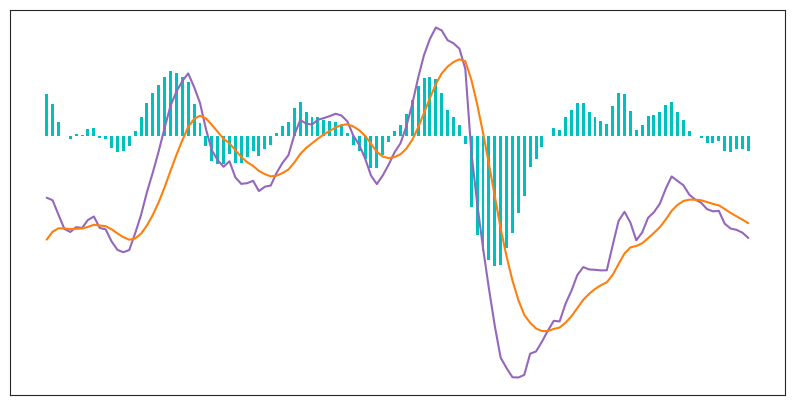

In [12]:

#update images in the corresponding folder for CNN classification 
X_train = windows
Y_train = pd.read_csv('Y_train.csv')

for idx in tqdm(range(len(tdf)), desc='images saved'):

    fig = plt.figure(figsize=(10, 5), num=1, clear=True)

    plt.plot(range(120), [X_train.loc[idx][f'open {i}'] for i in range(120)],'b',label='open')
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    fig.canvas.draw()
    image1 = PIL.Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
    

    fig = plt.figure(figsize=(10, 5), num=1, clear=True)

    plt.plot(range(120), [X_train.loc[idx][f'MACD {i}'] for i in range(120)],'C4',label='MACD')

    plt.plot(range(120), [X_train.loc[idx][f'MACD_Signal {i}'] for i in range(120)],'C1',label='Signal')

    Hist = [X_train.loc[idx][f'MACD {i}']-X_train.loc[idx][f'MACD_Signal {i}'] for i in range(120)]

    plt.bar(range(120), Hist, color='c',edgecolor='none', width=0.5,label='Hist')

    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    fig.canvas.draw()
    image2 = PIL.Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
    

    # Crop and merge the image
    width, height = image1.size
    left = 0.15*width
    top = 0.13*height
    right = 0.88*width
    bottom = 0.89*height 

    im1 = image1.crop((left, top, right, bottom))
    im2 = image2.crop((left, top, right, bottom))

    im1 = im1.resize((150,75))
    im2 = im2.resize((150,75))
    new_image = Image.new('RGB',(150,150), (255,255,255))
    new_image.paste(im1,(0,0))
    new_image.paste(im2,(0,75))
    
    #save the image in the folder
    new_image.save(f'CNN images/{idx+len(Y_train)-len(tdf)}.png')
    


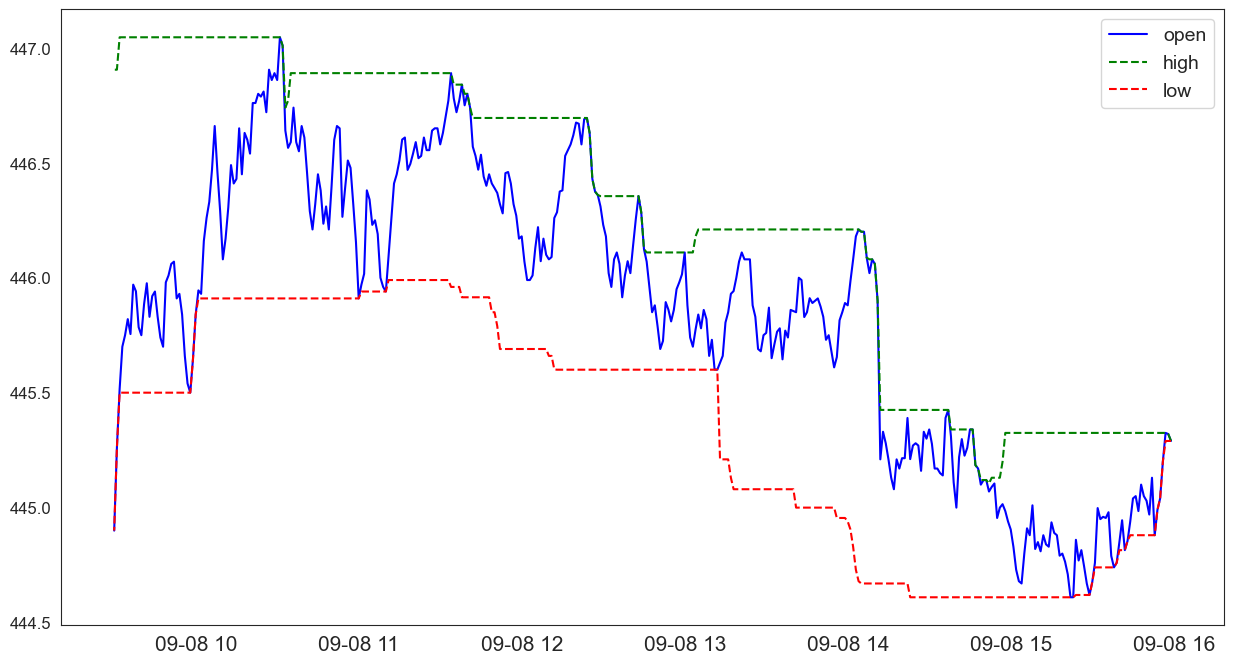

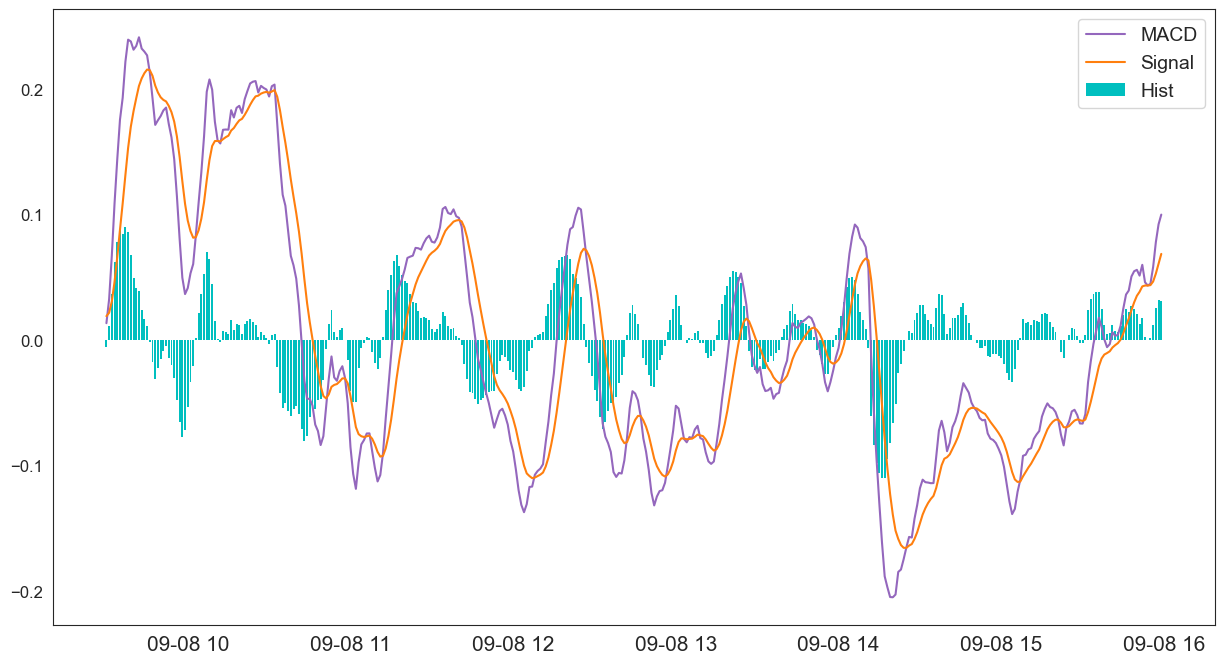

In [13]:
#Draw 'open', 'high', and 'low' for the last day
dfhlr = pd.read_csv('dfhlr.csv', parse_dates=['time'])
previousday = pd.Timestamp(dfhlr.time[0].year,dfhlr.time[0].month,dfhlr.time[0].day)
plt.figure(figsize=(15,8))
plt.plot(dfhlr.loc[dfhlr.time>=previousday].time,
         dfhlr.loc[dfhlr.time>=previousday].open,'b',label='open')
plt.plot(dfhlr.loc[dfhlr.time>=previousday].time,
         dfhlr.loc[dfhlr.time>=previousday].high,'g--',label='high')
plt.plot(dfhlr.loc[dfhlr.time>=previousday].time,
         dfhlr.loc[dfhlr.time>=previousday].low,'r--',label='low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

#Draw 'MACD', 'MACD_Signal', and 'MACD_Hist' for the last day
plt.figure(figsize=(15,8))
plt.plot(dfhlr.loc[dfhlr.time>=previousday].time,
         dfhlr.loc[dfhlr.time>=previousday].MACD,'C4',label='MACD')
plt.plot(dfhlr.loc[dfhlr.time>=previousday].time,
         dfhlr.loc[dfhlr.time>=previousday].MACD_Signal,'C1',label='Signal')
plt.bar(dfhlr.loc[dfhlr.time>=previousday].time,
         dfhlr.loc[dfhlr.time>=previousday].MACD_Hist,color='c',edgecolor='none',
                                                        width=0.0005,label='Hist')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()